# Run memento and compare to estimates from cellxgene estimators

In [65]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time

In [2]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [3]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

### Run memento

lets try cM vs T4

In [4]:
CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

CUBE_DIMS_VAR = ['feature_id']

TILEDB_SOMA_BUFFER_BYTES = 2**31

OBS_VALUE_FILTER = "is_primary_data == True and dataset_id ==  '218acb0f-9f2f-4f76-b90b-15a4b7c7f629' and donor_id == '1259'" # Lupus dataset


In [5]:
exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-18/soma/census_data/homo_sapiens'
measurement_name ='RNA'

In [6]:
with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "soma.init_buffer_bytes": TILEDB_SOMA_BUFFER_BYTES,
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())

In [7]:
lupus_adata=query.to_anndata('raw')

In [8]:
lupus_adata.var.index = lupus_adata.var.feature_id.tolist()

In [47]:
def run_memento(ct1, ct2):
    
    adata = lupus_adata[lupus_adata.obs['cell_type'].isin([ct1, ct2])].copy()

    adata.obs['q'] = 0.07
    memento.setup_memento(adata, q_column='q', trim_percent=1, filter_mean_thresh=0.1, shrinkage=0)
    memento.create_groups(adata, label_columns=['cell_type'])
    memento.compute_1d_moments(adata, min_perc_group=.7)

    meta_df = memento.get_groups(adata)
    meta_df['intercept'] = 1
    covariate = meta_df[['intercept']]
    treatment = (meta_df[['cell_type']] == ct2).astype(float)
        

    memento.ht_1d_moments(
        adata, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=13,
        resample_rep=False,
        approx=True)
    memento_results = memento.get_1d_ht_result(adata)
    
    return memento_results

In [48]:
memento_results = run_memento('classical monocyte','CD4-positive, alpha-beta T cell')

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    3.8s
[Parallel(n_jobs=13)]: Done 627 tasks      | elapsed:    7.8s
[Parallel(n_jobs=13)]: Done 1327 tasks      | elapsed:   14.3s
[Parallel(n_jobs=13)]: Done 1473 out of 1498 | elapsed:   15.7s remaining:    0.3s
[Parallel(n_jobs=13)]: Done 1498 out of 1498 | elapsed:   16.3s finished


### Run memento-cxg

Take the estimators from the cube and perform DE

In [49]:
def _fit_mv_regressor(mean, var):
	"""
		Perform regression of the variance against the mean.
	"""
	
	cond = (mean > 0) & (var > 0)
	m, v = np.log(mean[cond]), np.log(var[cond])
	
	poly = np.polyfit(m, v, 2)
	return poly
	f = np.poly1d(z)

def _residual_variance(mean, var, mv_fit):
	
	cond = (mean > 0) & (var > 0)
	rv = np.zeros(mean.shape)*np.nan
	
	f = np.poly1d(mv_fit)
	with np.errstate(invalid='ignore'):
		rv[cond] = np.exp(np.log(var[cond]) - f(np.log(mean[cond])))
	return rv

def compute_residual_variance(df):
    
    m = df['mean']
    v = df['var']
    vv = df['sev']
    mv_fit = _fit_mv_regressor(m, v)
    rv = _residual_variance(m, v, mv_fit)
    df['res_var'] = rv

In [50]:
donor = '1259'

In [51]:
cube_path + 'estimators_cube'

'/home/ubuntu/Github/memento-cxg/estimators_cube'

In [52]:
estimators = tiledb.open(cube_path + 'estimators_cube').df[:]

In [53]:
estimators = tiledb.open(cube_path + 'estimators_cube').df[:].query(f'donor_id == "{donor}"')\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [54]:
def compute_cxg_pvalues(ct1, ct2):
    
    ct1_df = estimators.query(f'cell_type == "{ct1}"').copy()
    ct2_df = estimators.query(f'cell_type == "{ct2}"').copy()
    compute_residual_variance(ct1_df)
    compute_residual_variance(ct2_df)
    
    merged = ct1_df.merge(ct2_df, on='feature_id', suffixes=('_ct1', '_ct2'))

    lfc = np.log(merged['mean_ct2'].values/merged['mean_ct1'].values)
    log_mean_se_1 = (np.log(merged['mean_ct1'] + merged['sem_ct1']) - np.log(merged['mean_ct1'] - merged['sem_ct1']))/2
    log_mean_se_2 = (np.log(merged['mean_ct2'] + merged['sem_ct2']) - np.log(merged['mean_ct2'] - merged['sem_ct2']))/2
    se_lfc = np.sqrt((log_mean_se_2**2 + log_mean_se_1**2)).values
    de_pvalues = stats.norm.sf(np.abs(lfc), loc=0, scale=se_lfc)*2

    dv_lfc = np.log(merged['res_var_ct2'].values/merged['res_var_ct1'].values)
    se_dv_lfc = np.sqrt((merged['selv_ct1']**2 + merged['selv_ct2']**2)).values
    dv_pvalues = stats.norm.sf(np.abs(dv_lfc), loc=0, scale=se_dv_lfc)*2

    cxg_results = pd.DataFrame(
        zip(
            merged['feature_id'].values,
            lfc,
            se_lfc,
            de_pvalues,
            dv_lfc,
            se_dv_lfc,
            dv_pvalues),
        columns=['gene', 'cxg_de_coef', 'cxg_de_se', 'cxg_de_pval', 'cxg_dv_coef', 'cxg_dv_se', 'cxg_dv_pval'])
    return cxg_results

In [55]:
cxg_results = compute_cxg_pvalues('classical monocyte','CD4-positive, alpha-beta T cell')

In [56]:
cxg_results = cxg_results.dropna()

### Compare the results

In [57]:
merged_results = memento_results.merge(cxg_results, on='gene')

In [58]:
merged_results['cxg_de_logp'] = -np.log10(merged_results['cxg_de_pval'])
merged_results['mem_de_logp'] = -np.log10(merged_results['de_pval'])

merged_results['cxg_dv_logp'] = -np.log10(merged_results['cxg_dv_pval'])
merged_results['mem_dv_logp'] = -np.log10(merged_results['dv_pval'])

/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Default')

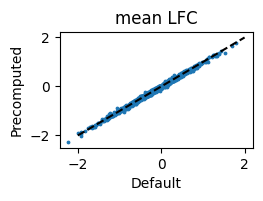

In [59]:
plt.figure(figsize=(2.5,1.5))
to_show = merged_results.query('mem_de_logp < 200 & cxg_de_logp < 200')

plt.scatter(
    to_show['de_coef'],
    to_show['cxg_de_coef'],
    s=3)
plt.title('mean LFC')
plt.ylabel('Precomputed')
plt.plot([-2, 2], [-2, 2], '--', color='k')
plt.xlabel('Default')

Text(0.5, 0, 'Default')

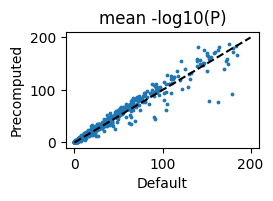

In [60]:
plt.figure(figsize=(2.5,1.5))
to_show = merged_results.query('mem_de_logp < 200 & cxg_de_logp < 200')

plt.scatter(
    to_show['mem_de_logp'],
    to_show['cxg_de_logp'],
    s=3)
plt.title('mean -log10(P)')
plt.ylabel('Precomputed')
plt.plot([0, 200], [0, 200], '--', color='k')
plt.xlabel('Default')

Text(0.5, 0, 'Default')

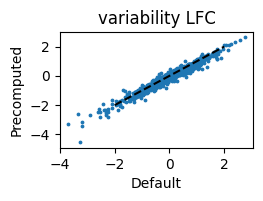

In [61]:
plt.figure(figsize=(2.5,1.5))
to_show = merged_results.query('dv_coef < 6 & cxg_dv_coef < 6 & mem_dv_logp < 25 & cxg_dv_logp < 25')

plt.scatter(
    to_show['dv_coef'],
    to_show['cxg_dv_coef'],
    s=3)
plt.title('variability LFC')
plt.ylabel('Precomputed')
plt.plot([-2, 2], [-2, 2], '--', color='k')
plt.xlabel('Default')

Text(0.5, 0, 'Default')

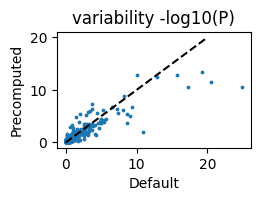

In [63]:
plt.figure(figsize=(2.5,1.5))
to_show = merged_results.query('dv_coef < 6 & cxg_dv_coef < 6 & mem_dv_logp < 25 & cxg_dv_logp < 25')
plt.scatter(
    to_show['mem_dv_logp'],
    to_show['cxg_dv_logp'],
    s=3)
plt.title('variability -log10(P)')
plt.plot([0, 20], [0, 20], '--', color='k')
plt.ylabel('Precomputed')
plt.xlabel('Default')


### Compare runtimes

In [ ]:
cell_types = lupus_adata.obs['cell_type'].drop_duplicates().tolist()

In [69]:
# Time cxg

num_cts = len(cell_types)
cxg_times = []
for nct in range(2, num_cts):
    
    cts_to_compare = itertools.combinations(cell_types[:nct], 2)
    
    start = time.time()
    for ct1, ct2 in cts_to_compare:
        
        # a = run_memento(ct1, ct2)
        b = compute_cxg_pvalues(ct1, ct2)
    duration = time.time()-start
    cxg_times.append(duration)


In [70]:
cxg_times

[0.0445709228515625,
 0.12334084510803223,
 0.24467754364013672,
 0.4052596092224121,
 0.5705969333648682,
 0.78609299659729,
 1.0434541702270508,
 1.396212100982666,
 1.4767653942108154]

In [ ]:
# Time memento

num_cts = len(cell_types)
memento_times = []
for nct in range(2, num_cts):
    
    cts_to_compare = itertools.combinations(cell_types[:nct], 2)
    
    start = time.time()
    for ct1, ct2 in cts_to_compare:
        
        a = run_memento(ct1, ct2)
    duration = time.time()-start
    memento_times.append(duration)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    3.8s
[Parallel(n_jobs=13)]: Done 627 tasks      | elapsed:    7.9s
[Parallel(n_jobs=13)]: Done 1327 tasks      | elapsed:   14.3s
[Parallel(n_jobs=13)]: Done 1436 out of 1436 | elapsed:   15.5s finished
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    3.0s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:    7.5s
[Parallel(n_jobs=13)]: Done 1436 out of 1436 | elapsed:   13.6s finished
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    2.4s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:    6.2s
[P